In [13]:
import gym # loading the Gym library

_**note:**_ By default, the Frozen Lake environment provided in Gym has probabilistic transitions between states. In other words, even when our agent chooses to move in one direction, the environment can execute a movement in another direction. Also of interest is that the Frozen Lake environment allows for initialization of randomly generated maps with `map_name=None`, but this is not used here in our FrozenLake-v0 environment.

actions = {
    'Left': 0,
    'Down': 1,
    'Right': 2, 
    'Up': 3
}

# Exercise 1

In [14]:
from genrl.agents import QLearning
from genrl.trainers import ClassicalTrainer

In [15]:
total_episodes = 1000

env = gym.make("FrozenLake-v0")
env.reset()                    
env.render()
print("\nAction space: ", env.action_space)
print("Observation space: ", env.observation_space)


SFFF
FHFH
FFFH
HFFG

Action space:  Discrete(4)
Observation space:  Discrete(16)


Evaluating at the episode number: 0
Evaluating on 100 episodes, Mean Reward: 0.0 and Std Deviation for the reward: 0.0
Evaluating at the episode number: 500
Evaluating on 100 episodes, Mean Reward: 1.0 and Std Deviation for the reward: 0.0
Evaluating at the episode number: 1000
Evaluating on 100 episodes, Mean Reward: 0.0 and Std Deviation for the reward: 0.0
Evaluating at the episode number: 1000
Evaluating on 100 episodes, Mean Reward: 0.0 and Std Deviation for the reward: 0.0


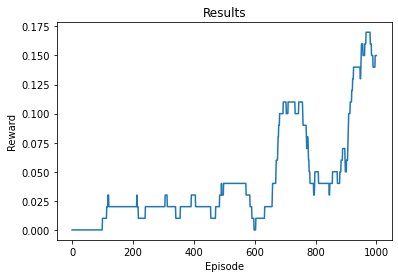

In [16]:
env = gym.make("FrozenLake-v0")
agent = QLearning(env)
trainer = ClassicalTrainer(agent, env, mode="dyna", model="tabular", n_episodes=total_episodes)
episode_rewards = trainer.train()
trainer.plot(episode_rewards)


# Exercise 2

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
env = gym.make('FrozenLake-v0')
total_episodes = 1000
win_pct = []
scores = []

obs = env.reset()
print(env.observation_space)

Discrete(16)


In [19]:
def get_next_action(state):
    # prefer down before right:
    # SFFF
    # FHFH
    # FFFH
    # HFFG
    # { 'Left': 0, 'Down': 1, 'Right': 2, 'Up': 3 }
    policy = {0: 1, 1:2, 2:1, 3:0, 4: 1, 6: 1, 8:2, 9:1, 10:1, 13: 2, 14:2}
    return policy[state]

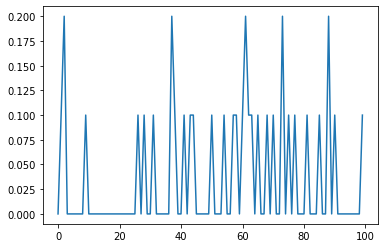

In [20]:
for i in range(total_episodes):
    done = False
    state = env.reset()
    score = 0   
    while not done:
        # some_action = env.action_space.sample() #samples a random action
        next_action = get_next_action(state)
        state, reward, done, info = env.step(next_action) #agent takes action (random_action)
        score += reward
        
    scores.append(score)

    if (i + 1) % 10 == 0:
        average = np.mean(scores[-10:])
        win_pct.append(average)

plt.plot(win_pct)
plt.show()

# Exercise 3

- initialize Q for all states and actions
- set alpha to 0.001 gamma to 0.9 epsilon_max to 1 and espilon_min to 0.01

In [21]:
import random

In [22]:
env = gym.make('FrozenLake-v0')
total_episodes = 500000

env.reset()

Q = np.zeros((env.observation_space.n, env.action_space.n))
alpha = 0.001
gamma = 0.9
epsilon_max = 1.0 # 0.5 is better, with a dec mod of about 0.075
epsilon_min = 0.01

In [23]:
class Agent:
    def __init__(self, Q, alpha, gamma, n_episodes, n_actions, epsilon_max=1.0, epsilon_min=0, epsilon_dec_mod=0.125):
        """ 
            with a mod of 0.1, epsilon will decrement by 0.9999996 in training on 500,000 episodes.
            with a mod of 0.125, epsilon will decrement by 0.9999995 in training on 500,000 episodes, never reaching min.
            with a mod of 0.25, epsilon will decrement by 0.999999 in training on 500,000 episodes, approaching min after 80%.
            with a mod of 0.5, epsilon will decrement by 0.999998 in training on 500,000 episodes, approaching min after 60%.
            with a mod of 1, epsilon will decrement by 0.999996 in training on 500,000 episodes, approaching min after 20%.
        """
        self.Q = Q
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor
        self.n_actions = n_actions
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_dec = (1-(1/n_episodes) * epsilon_dec_mod) ** 2
        self.epsilon = epsilon_max
        self.state = None

    def __decrement_epsilon(self):
        self.epsilon = self.epsilon * self.epsilon_dec if self.epsilon > self.epsilon_min \
                        else self.epsilon_min
    
    def select_action(self,): # apply epsilon greedy 
        if random.uniform(0,1) < self.epsilon: # explore - random action
            action = np.random.choice([i for i in range(self.n_actions)])
        else: # exploit - a_max in Q at state
            action = np.argmax([self.Q[state, a] for a in range(self.n_actions)])
        return action

    def update(self, state, action, reward):
        self.Q[self.state, action] += self.alpha * (reward + self.gamma * \
            np.max(self.Q[state]) - self.Q[self.state, action])

        self.state = state
        self.__decrement_epsilon()


- repeat for n_episodes
- - initialize state s
- - for each step of episode
- - - choose an action based on state s with an epsilon_greedy strategy in Q 
- - - take the action, get new_state and reward.
- - - update with the new reward, pluggin in to the equation below in Q:
Q(s,a) = Q(s,a) + alpha * (r + gamme * max(Q(s', a_max))-Q(s,a))
- - - update state

0.4425279336280841 0.04
0.3917628883789365 0.04
0.34357896554749695 0.17
0.27583748062808927 0.12
0.2330814448954696 0.04
0.20291058845161905 0.1
0.16403096404318868 0.13
0.13983057388650164 0.05
0.11379688944830482 0.07
0.088502842402558 0.12
0.088502842402558 0.12


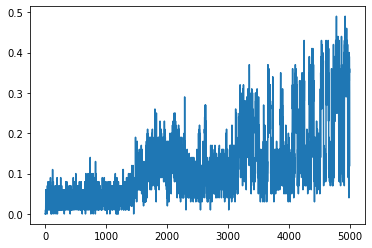

In [24]:
agent = Agent(Q, alpha, gamma, total_episodes, env.action_space.n, epsilon_max, epsilon_min)
win_pct = []
scores = []

for i in range(total_episodes):
    state = env.reset()
    score = 0
    done = False
    while not done:
        next_action = agent.select_action()
        state, reward, done, info = env.step(next_action)
        agent.update(state, next_action, reward)
        score += reward
        
    scores.append(score)

    if (i + 1) % 100 == 0:
        average = np.mean(scores[-100:])
        win_pct.append(average)
    if (i + 1) % (total_episodes * 0.1) == 0:
        print(agent.epsilon, average)
print(agent.epsilon, average)

plt.plot(win_pct)
plt.show()